In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

In [30]:
def get_model_sim_results(params, tta_condition, n_trials=10000):
    tta_crit, noise_intensity, delay_mean, delay_std = params
    
    noise = noise_intensity*np.random.randn(n_trials)
    perceived_tau = tta_condition + noise
    
    rts = delay_mean + delay_std*np.random.randn(n_trials)
    rts[rts<0] = 0
    
    sim_result = pd.DataFrame({'perceived_tta': perceived_tau, 'RT': rts})
    sim_result['tta_condition'] = tta_condition
    sim_result['is_turn_decision'] = sim_result['perceived_tta'] > tta_crit
    
    return sim_result
    
def model_error_wls_per_condition(exp_data, model_measures):
    # weighted least squares fitting, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_data.is_turn_decision.mean()
    p_model = model_measures.is_turn_decision.mean()
    delta_p = (p_model - p_exp)**2

    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]

    model_rt_quantiles = model_measures[model_measures.is_turn_decision].RT.quantile(rt_quantiles)
    if p_model==0:
        model_rt_quantiles.loc[:] = 0
        
    exp_rt_quantiles = exp_data[exp_data.is_turn_decision].RT.quantile(rt_quantiles)    
    
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(model_measures, exp_data):
    error = [model_error_wls_per_condition(model_measures[model_measures.tta_condition==tta],
                                           exp_data[exp_data.tta_condition==tta]) for tta in [4, 5, 6]]
    return sum(error)

def f_wls(params):    
    exp_data = pd.read_csv('measures.csv')
    model_measures = pd.concat([get_model_sim_results(params=params, tta_condition=tta) for tta in [4, 5, 6]])
    f = model_error_wls(model_measures, exp_data)
#     print(f, params)
    return f

In [ ]:
# typical values (5.3, 1.0, 0.6, 0.25)
# tta_crit, noise_intensity, delay_mean, delay_std = params
bounds = [(3, 6), (0.1, 2.0), (0.0, 1.0), (0.0, 0.5)]
fit_result = differential_evolution(f_wls, bounds)

In [12]:
params = fit_result.x

In [17]:
model_measures = pd.concat([get_model_sim_results(params=params, tta_condition=tta) for tta in [4, 5, 6]])

In [21]:
model_measures = model_measures[model_measures.tta_condition==4]
exp_data = exp_data[exp_data.tta_condition==4]

In [22]:
p_exp = exp_data.is_turn_decision.mean()
p_model = model_measures.is_turn_decision.mean()
delta_p = (p_model - p_exp)**2

rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
rt_q_weights = [2, 2, 1, 1, 0.5]

model_rt_quantiles = model_measures[model_measures.is_turn_decision].RT.quantile(rt_quantiles)
exp_rt_quantiles = exp_data[exp_data.is_turn_decision].RT.quantile(rt_quantiles)    

0.1    0.0
0.3    0.0
0.5    0.0
0.7    0.0
0.9    0.0
Name: RT, dtype: float64

# Obsolete

In [4]:
def get_measures(trial_log, tta_crit, nondecision_time):
    idx_ndt = np.where(trial_log.t>nondecision_time)[0][0]
#     print(trial_log.x.values[idx_ndt])
    is_turn_decision = trial_log.x.values[idx_ndt] > tta_crit
    return is_turn_decision

condition = (6, 90)
params = (0.8, 0.4, 4.5)
tta_condition, distance_condition = condition
noise_intensity, nondecision_time, tta_crit = params
n_sim=1000
t_max=2.5
dt=0.01

noise = np.random.randn(n_sim, int(t_max/dt))
t = np.arange(0, t_max, dt)
tau = np.arange(tta_condition, tta_condition-t_max, -dt)
x = tau + noise_intensity*noise
# this assumes that stimulus is not perceived during nondecision time
# x[:,tta_condition-tau<nondecision_time] = np.nan
df = pd.DataFrame({'t': np.tile(t, n_sim), 
                   'x': pd.DataFrame(x).stack(dropna=False)}).reset_index()
df = df.rename(columns = {'level_0': 'trial', 'level_1': 'i'})

decisions = df.groupby('trial').apply(lambda trial_log: get_measures(trial_log, tta_crit, nondecision_time))
p_turn = decisions.mean()
print(p_turn)

0.929


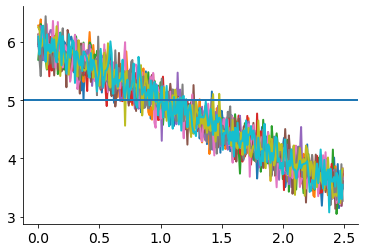

In [63]:
fig, ax = plt.subplots(1)
for x_i in x[:10]:
    ax.plot(tta_condition-tau, x_i)
    
ax.axhline(tta_crit)